# PBMC isoforms

Zoë Steier and Adam Gayoso

* Dataset: PBMC10k
* Autocorrelation of features in different latent spaces
* Proteins contain CD45 isoforms

## Imports and settings

In [1]:
# Import required packages

import csv
import gzip
import os
import scipy.io
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import torch
import sys

import scvi
from scvi.dataset import GeneExpressionDataset, CellMeasurement, AnnDatasetFromAnnData
from scvi.models import VAE, TOTALVI
from scvi.inference import TotalPosterior, TotalTrainer, Posterior, UnsupervisedTrainer

import anndata
import scanpy as sc
import umap

from typing import Optional

from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import normalize

from scvi import set_seed

save_path = "/data/yosef2/users/adamgayoso/projects/totalVI_journal/data/"
%load_ext autoreload
%autoreload 2
%matplotlib inline
overwrite=True

set_seed(0)

In [2]:
# GPU settings

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
os.environ['CUDA_VISIBLE_DEVICES']='1'

In [3]:
# Plotting settings

colors = ["#3B7EA1", "#FDB515", "#D9661F", "#859438", "#EE1F60", "#00A598"]
sns.set(context="notebook", font_scale=1.3, style="ticks")
sns.set_palette(sns.color_palette(colors))
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['savefig.transparent'] = True
plt.rcParams['figure.figsize'] = (4, 4)

sc.settings._vector_friendly = True
DPI = 300
W_SPACE = 0.18

## Load data

In [4]:
anndataset_5k = anndata.read(save_path + "pbmc_10k_protein_v3.h5ad")

In [5]:
anndataset_5k.uns["protein_names"]

array(['CD3_TotalSeqB', 'CD4_TotalSeqB', 'CD8a_TotalSeqB',
       'CD14_TotalSeqB', 'CD15_TotalSeqB', 'CD16_TotalSeqB',
       'CD56_TotalSeqB', 'CD19_TotalSeqB', 'CD25_TotalSeqB',
       'CD45RA_TotalSeqB', 'CD45RO_TotalSeqB', 'PD-1_TotalSeqB',
       'TIGIT_TotalSeqB', 'CD127_TotalSeqB'], dtype=object)

In [6]:
anndataset_5k.var.highly_variable.loc["PTPRC"] = True

anndataset_5k = anndataset_5k[:, anndataset_5k.var.highly_variable]

/data/yosef2/users/zsteier/programs/miniconda/envs/scvi_041/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [7]:
dataset_5k = AnnDatasetFromAnnData(ad = anndataset_5k)
protein_data_5k = CellMeasurement(name="protein_expression", data=anndataset_5k.obsm["protein_expression"].astype(np.float32), 
                               columns_attr_name="protein_names", columns=anndataset_5k.uns["protein_names"])
dataset_5k.initialize_cell_measurement(protein_data_5k)

[2020-12-17 11:15:32,938] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-12-17 11:15:32,940] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-12-17 11:15:32,993] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-12-17 11:15:33,039] INFO - scvi.dataset.dataset | Downsampled from 6855 to 6855 cells


## Run totalVI

In [8]:
model = TOTALVI(
    dataset_5k.nb_genes,
    dataset_5k.protein_expression.shape[1],
    encoder_batch=True
)
use_cuda = True
lr = 4e-3
early_stopping_kwargs = {
    "early_stopping_metric": "elbo",
    "save_best_state_metric": "elbo",
    "patience": 45,
    "threshold": 0,
    "reduce_lr_on_plateau": True,
    "lr_patience": 30,
    "lr_factor": 0.6,
    "posterior_class": TotalPosterior,
}

trainer = TotalTrainer(
    model,
    dataset_5k,
    train_size=0.90,
    test_size=0.10,
    use_cuda=use_cuda,
    frequency=1,
    data_loader_kwargs={"batch_size": 256},
    early_stopping_kwargs=early_stopping_kwargs,
)
trainer.train(lr=lr, n_epochs=500)

[2020-12-17 11:23:05,478] INFO - scvi.inference.trainer | Reducing LR on epoch 443.
[2020-12-17 11:23:45,705] INFO - scvi.inference.trainer | Reducing LR on epoch 484.



In [10]:
# create posterior on full data
full_posterior = trainer.create_posterior(
    model, dataset_5k, indices=np.arange(len(dataset_5k)), type_class=TotalPosterior
)
# extract latent space
latent_mean, batch_index, label, library_gene = full_posterior.sequential().get_latent()

# Number of Monte Carlo samples to average over
n_samples = 25

parsed_protein_names = [p.split("_")[0] for p in dataset_5k.protein_names]

denoised_genes, denoised_proteins = full_posterior.sequential().get_normalized_denoised_expression(
    n_samples=n_samples, give_mean=True, transform_batch=0
)

In [11]:
post_adata = anndata.AnnData(X=dataset_5k.X.copy())
post_adata.var.index = dataset_5k.gene_names
sc.pp.normalize_total(post_adata, target_sum=1e4) # normalize rna data (raw)
sc.pp.log1p(post_adata)
post_adata.raw = post_adata
post_adata.obsm["X_totalVI"] = latent_mean
sc.pp.neighbors(post_adata, use_rep="X_totalVI", n_neighbors=20, metric="correlation")
sc.tl.umap(post_adata, min_dist=0.5)
sc.tl.leiden(post_adata, key_added="leiden_totalVI")

/data/yosef2/users/zsteier/programs/miniconda/envs/scvi_041/lib/python3.7/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../programs/miniconda/envs/scvi_041/lib/python3.7/site-packages/umap/utils.py", line 409:
@numba.njit(parallel=True)
def build_candidates(current_graph, n_vertices, n_neighbors, max_candidates, rng_state):
^

  current_graph, n_vertices, n_neighbors, max_candidates, rng_state
/data/yosef2/users/zsteier/programs/miniconda/envs/scvi_041/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pyda

In [12]:
for i, p in enumerate(parsed_protein_names):
    post_adata.obs["{} Protein".format(p)] = np.log1p(anndataset_5k.obsm["protein_expression"][:, i]) # normalize proteins

In [13]:
anndataset_5k.obsm["protein_expression"].shape

(6855, 14)

## Run scVI

In [14]:
adata_rna = anndata.AnnData(anndataset_5k.X.copy(), var = anndataset_5k.var.copy())

In [15]:
adata_rna

AnnData object with n_obs × n_vars = 6855 × 4001 
    var: 'n_cells', 'highly_variable', 'encode', 'hvg_encode'

In [16]:
dataset_scvi = AnnDatasetFromAnnData(ad=adata_rna)

[2020-12-17 11:26:29,092] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-12-17 11:26:29,093] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-12-17 11:26:29,140] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-12-17 11:26:29,197] INFO - scvi.dataset.dataset | Downsampled from 6855 to 6855 cells


In [17]:
use_cuda = True

scvi_vae = VAE(dataset_scvi.nb_genes, reconstruction_loss="nb", n_latent=20)
scvi_trainer = UnsupervisedTrainer(
    scvi_vae,
    dataset_scvi,
    train_size=0.90,
    test_size=0.10,
    use_cuda=use_cuda,
    frequency=10,
    data_loader_kwargs={"pin_memory": False} # no batch_size for scVI
)

In [18]:
lr = 2e-3

scvi_trainer.train(lr = 4e-3, n_epochs = 300)

[2020-12-17 11:26:39,246] INFO - scvi.inference.inference | KL warmup phase exceeds overall training phaseIf your applications rely on the posterior quality, consider training for more epochs or reducing the kl warmup.



[2020-12-17 11:30:53,866] INFO - scvi.inference.inference | Training is still in warming up phase. If your applications rely on the posterior quality, consider training for more epochs or reducing the kl warmup.


In [19]:
# create scVI posterior

full_scvi_posterior = scvi_trainer.create_posterior(
    scvi_vae, dataset_scvi, indices=np.arange(len(dataset_scvi)),
)

In [20]:
# extract latent space

latent_mean_scvi, batch_index, label = full_scvi_posterior.sequential().get_latent()

In [21]:
post_adata_scvi = anndata.AnnData(post_adata.X, obs = post_adata.obs, var = post_adata.var)
post_adata_scvi.obsm["X_scVI"] = latent_mean_scvi
post_adata_scvi

AnnData object with n_obs × n_vars = 6855 × 4001 
    obs: 'leiden_totalVI', 'CD3 Protein', 'CD4 Protein', 'CD8a Protein', 'CD14 Protein', 'CD15 Protein', 'CD16 Protein', 'CD56 Protein', 'CD19 Protein', 'CD25 Protein', 'CD45RA Protein', 'CD45RO Protein', 'PD-1 Protein', 'TIGIT Protein', 'CD127 Protein'
    obsm: 'X_scVI'

In [22]:
sc.pp.normalize_total(post_adata_scvi, target_sum=1e4) # normalize rna data (raw)
sc.pp.log1p(post_adata_scvi)
post_adata_scvi.raw = post_adata_scvi

In [23]:
# find neighbors

sc.pp.neighbors(post_adata_scvi, use_rep="X_scVI", n_neighbors=20, metric="correlation")
sc.tl.umap(post_adata_scvi, min_dist=0.5)

/data/yosef2/users/zsteier/programs/miniconda/envs/scvi_041/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../programs/miniconda/envs/scvi_041/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))


In [24]:
for i, p in enumerate(parsed_protein_names):
    post_adata_scvi.obs["{} Protein".format(p)] = np.log1p(anndataset_5k.obsm["protein_expression"][:, i]) # normalize proteins (raw)

## Plot isoforms

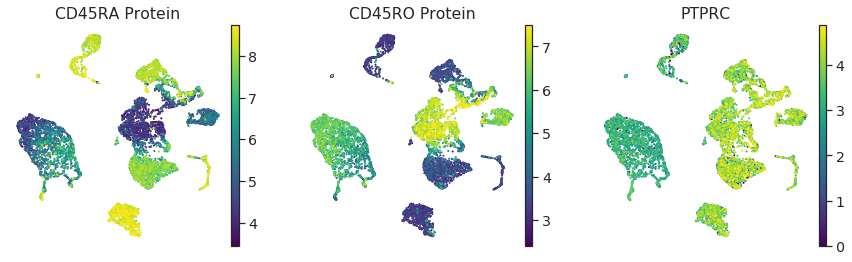

In [27]:
# Plot totalVI

fig = sc.pl.umap(
    post_adata,
    color=["CD45RA Protein", "CD45RO Protein", "PTPRC"],
    return_fig=True,
    frameon=False,
    cmap=plt.cm.viridis,
    vmin = "p01",
    vmax = "p99"
)

#plt.savefig("figures/isoforms_totalVI.pdf", dpi=DPI, bbox_inches="tight")

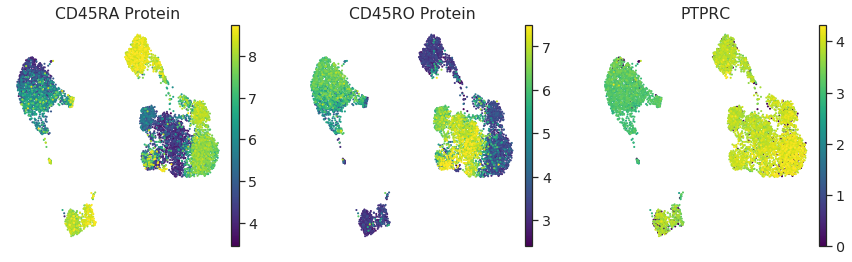

In [26]:
# Plot scVI

fig = sc.pl.umap(
    post_adata_scvi,
    color=["CD45RA Protein", "CD45RO Protein", "PTPRC"],
    return_fig=True,
    frameon=False,
    cmap=plt.cm.viridis,
    vmin = "p01",
    vmax = "p99"
)

#plt.savefig("figures/isoforms_scVI.pdf", dpi=DPI, bbox_inches="tight")

## Protein only

In [57]:
adata_protein = anndata.AnnData(anndataset_5k.obsm["protein_expression"].copy())

sc.pp.log1p(adata_protein) 
sc.pp.scale(adata_protein)
adata_protein

AnnData object with n_obs × n_vars = 6855 × 14 
    uns: 'log1p'

In [58]:
# Find neighbors
sc.pp.neighbors(adata_protein, n_neighbors=20, metric="correlation")

/data/yosef2/users/zsteier/programs/miniconda/envs/scvi_041/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../programs/miniconda/envs/scvi_041/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))


In [59]:
sc.tl.umap(adata_protein, min_dist=0.5)

In [60]:
for i, p in enumerate(parsed_protein_names):
    adata_protein.obs["{} Protein".format(p)] = np.log1p(anndataset_5k.obsm["protein_expression"][:, i]) # normalize proteins (raw)

In [69]:
post_adata.X[:, np.where(post_adata.var.index == "PTPRC")[0][0]]

array([3.180947 , 3.0040762, 3.0694735, ..., 3.8808355, 3.7720566,
       3.9155293], dtype=float32)

In [70]:
adata_protein.obs["PTPRC"] = post_adata.X[:, np.where(post_adata.var.index == "PTPRC")[0][0]]

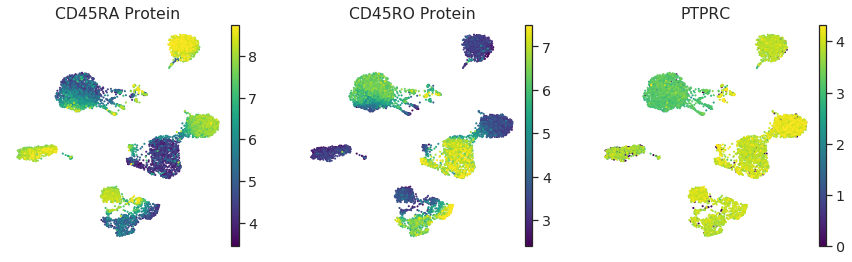

In [71]:
# Plot totalVI

fig = sc.pl.umap(
    adata_protein,
    color=["CD45RA Protein", "CD45RO Protein", "PTPRC"],
    return_fig=True,
    frameon=False,
    cmap=plt.cm.viridis,
    vmin = "p01",
    vmax = "p99"
)

#plt.savefig("figures/isoforms_totalVI.pdf", dpi=DPI, bbox_inches="tight")

## Autocorrelation

In [28]:
# code from https://github.com/ivirshup/scanpy/blob/metrics/scanpy/metrics/_gearys_c.py
from typing import Optional, Union

from anndata import AnnData
from multipledispatch import dispatch
import numba
import numpy as np
import pandas as pd
from scipy import sparse


def _choose_obs_rep(adata, *, use_raw=False, layer=None, obsm=None, obsp=None):
    """
    Choose array aligned with obs annotation.
    """
    is_layer = layer is not None
    is_raw = use_raw is not False
    is_obsm = obsm is not None
    is_obsp = obsp is not None
    choices_made = sum((is_layer, is_raw, is_obsm, is_obsp))
    assert choices_made <= 1
    if choices_made == 0:
        return adata.X
    elif is_layer:
        return adata.layers[layer]
    elif use_raw:
        return adata.raw.X
    elif is_obsm:
        return adata.obsm[obsm]
    elif is_obsp:
        return adata.obsp[obsp]
    else:
        assert False, (
            "That was unexpected. Please report this bug at:\n\n\t"
            " https://github.com/theislab/scanpy/issues"
        )



###############################################################################
# Calculation
###############################################################################
# Some notes on the implementation:
# * This could be phrased as tensor multiplication. However that does not get
#   parallelized, which boosts performance almost linearly with cores.
# * Due to the umap setting the default threading backend, a parallel numba
#   function that calls another parallel numba function can get stuck. This
#   ends up meaning code re-use will be limited until umap 0.4.
#   See: https://github.com/lmcinnes/umap/issues/306
# * There can be a fair amount of numerical instability here (big reductions),
#   so data is cast to float64. Removing these casts/ conversion will cause the
#   tests to fail.


@numba.njit(cache=True, parallel=True)
def _gearys_c_vec(data, indices, indptr, x):
    W = data.sum()
    return _gearys_c_vec_W(data, indices, indptr, x, W)


@numba.njit(cache=True, parallel=True)
def _gearys_c_vec_W(data, indices, indptr, x, W):
    N = len(indptr) - 1
    x_bar = x.mean()
    x = x.astype(np.float_)

    total = 0.0
    for i in numba.prange(N):
        s = slice(indptr[i], indptr[i + 1])
        i_indices = indices[s]
        i_data = data[s]
        total += np.sum(i_data * ((x[i] - x[i_indices]) ** 2))

    numer = (N - 1) * total
    denom = 2 * W * ((x - x_bar) ** 2).sum()
    C = numer / denom

    return C


@numba.njit(cache=True, parallel=True)
def _gearys_c_mtx_csr(
    g_data, g_indices, g_indptr, x_data, x_indices, x_indptr, x_shape
):
    M, N = x_shape
    W = g_data.sum()
    out = np.zeros(M, dtype=np.float_)
    for k in numba.prange(M):
        x_k = np.zeros(N, dtype=np.float_)
        sk = slice(x_indptr[k], x_indptr[k + 1])
        x_k_data = x_data[sk]
        x_k[x_indices[sk]] = x_k_data
        x_k_bar = np.sum(x_k_data) / N
        total = 0.0
        for i in numba.prange(N):
            s = slice(g_indptr[i], g_indptr[i + 1])
            i_indices = g_indices[s]
            i_data = g_data[s]
            total += np.sum(i_data * ((x_k[i] - x_k[i_indices]) ** 2))
        numer = (N - 1) * total
        # Expanded from 2 * W * ((x_k - x_k_bar) ** 2).sum(), but uses sparsity
        # to skip some calculations
        # fmt: off
        denom = (
            2 * W
            * (
                np.sum(x_k_data ** 2)
                - np.sum(x_k_data * x_k_bar * 2)
                + (x_k_bar ** 2) * N
            )
        )
        C = numer / denom
        out[k] = C
    return out


# Simplified implementation, hits race condition after umap import due to numba
# parallel backend
# @numba.njit(cache=True, parallel=True)
# def _gearys_c_mtx_csr(
#     g_data, g_indices, g_indptr, x_data, x_indices, x_indptr, x_shape
# ):
#     M, N = x_shape
#     W = g_data.sum()
#     out = np.zeros(M, dtype=np.float64)
#     for k in numba.prange(M):
#         x_arr = np.zeros(N, dtype=x_data.dtype)
#         sk = slice(x_indptr[k], x_indptr[k + 1])
#         x_arr[x_indices[sk]] = x_data[sk]
#         outval = _gearys_c_vec_W(g_data, g_indices, g_indptr, x_arr, W)
#         out[k] = outval
#     return out


@numba.njit(cache=True, parallel=True)
def _gearys_c_mtx(g_data, g_indices, g_indptr, X):
    M, N = X.shape
    W = g_data.sum()
    out = np.zeros(M, dtype=np.float_)
    for k in numba.prange(M):
        x = X[k, :].astype(np.float_)
        x_bar = x.mean()

        total = 0.0
        for i in numba.prange(N):
            s = slice(g_indptr[i], g_indptr[i + 1])
            i_indices = g_indices[s]
            i_data = g_data[s]
            total += np.sum(i_data * ((x[i] - x[i_indices]) ** 2))

        numer = (N - 1) * total
        denom = 2 * W * ((x - x_bar) ** 2).sum()
        C = numer / denom

        out[k] = C
    return out


# Similar to above, simplified version umaps choice of parallel backend breaks:
# @numba.njit(cache=True, parallel=True)
# def _gearys_c_mtx(g_data, g_indices, g_indptr, X):
#     M, N = X.shape
#     W = g_data.sum()
#     out = np.zeros(M, dtype=np.float64)
#     for k in numba.prange(M):
#         outval = _gearys_c_vec_W(g_data, g_indices, g_indptr, X[k, :], W)
#         out[k] = outval
#     return out


###############################################################################
# Interface
###############################################################################


@dispatch(sparse.csr_matrix, sparse.csr_matrix)
def gearys_c(g, vals) -> np.ndarray:
    assert g.shape[0] == g.shape[1], "`g` should be a square adjacency matrix"
    assert g.shape[0] == vals.shape[1]
    return _gearys_c_mtx_csr(
        g.data.astype(np.float_, copy=False),
        g.indices,
        g.indptr,
        vals.data.astype(np.float_, copy=False),
        vals.indices,
        vals.indptr,
        vals.shape,
    )


@dispatch(sparse.spmatrix, np.ndarray)  # noqa
def gearys_c(g, vals):
    """\
    Params
    ------
    g
        Connectivity graph as a scipy sparse matrix. Should have shape:
        `(n_obs, n_obs)`.
    vals
        Values to calculate Geary's C for. If one dimensional, should have
        shape `(n_obs,)`. If two dimensional (i.e calculating Geary's C for
        multiple variables) should have shape `(n_vars, n_obs)`.
    """
    assert g.shape[0] == g.shape[1], "`g` should be a square matrix."
    if not isinstance(g, sparse.csr_matrix):
        g = g.tocsr()
    g_data = g.data.astype(np.float_, copy=False)
    if vals.ndim == 1:
        assert g.shape[0] == vals.shape[0]
        return _gearys_c_vec(g_data, g.indices, g.indptr, vals)
    elif vals.ndim == 2:
        assert g.shape[0] == vals.shape[1]
        return _gearys_c_mtx(g_data, g.indices, g.indptr, vals)
    else:
        raise ValueError()


@dispatch(sparse.spmatrix, (pd.DataFrame, pd.Series))  # noqa
def gearys_c(g, vals):
    return gearys_c(g, vals.values)


@dispatch(sparse.spmatrix, sparse.spmatrix)  # noqa
def gearys_c(g, vals) -> np.ndarray:
    if not isinstance(g, sparse.csr_matrix):
        g = g.tocsr()
    if not isinstance(vals, sparse.csr_matrix):
        vals = vals.tocsr()
    return gearys_c(g, vals)


# TODO: Document better
# TODO: Have scanpydoc work with multipledispatch
@dispatch(AnnData)  # noqa
def gearys_c(
    adata: AnnData,
    *,
    vals: Optional[Union[np.ndarray, sparse.spmatrix]] = None,
    use_graph: Optional[str] = None,
    layer: Optional[str] = None,
    obsm: Optional[str] = None,
    obsp: Optional[str] = None,
    use_raw: bool = False,
) -> Union[np.ndarray, float]:
    """\
    Calculate `Geary's C` <https://en.wikipedia.org/wiki/Geary's_C>`_, as used
    by `VISION <https://doi.org/10.1038/s41467-019-12235-0>`_.
    Geary's C is a measure of autocorrelation for some measure on a graph. This
    can be to whether measures are correlated between neighboring cells. Lower
    values indicate greater correlation.
    ..math
        C =
        \frac{
            (N - 1)\sum_{i,j} w_{i,j} (x_i - x_j)^2
        }{
            2W \sum_i (x_i - \bar{x})^2
        }
    Params
    ------
    adata
    vals
        Values to calculate Geary's C for. If this is two dimensional, should
        be of shape `(n_features, n_cells)`. Otherwise should be of shape
        `(n_cells,)`. This matrix can be selected from elements of the anndata
        object by using key word arguments: `layer`, `obsm`, `obsp`, or
        `use_raw`.
    use_graph
        Key to use for graph in anndata object. If not provided, default
        neighbors connectivities will be used instead.
    layer
        Key for `adata.layers` to choose `vals`.
    obsm
        Key for `adata.obsm` to choose `vals`.
    obsp
        Key for `adata.obsp` to choose `vals`.
    use_raw
        Whether to use `adata.raw.X` for `vals`.
    Returns
    -------
    If vals is two dimensional, returns a 1 dimensional ndarray array. Returns
    a scalar if `vals` is 1d.
    """
    if use_graph is None:
        # Fix for anndata<0.7
        if hasattr(adata, "obsp") and "connectivities" in adata.obsp:
            g = adata.obsp["connectivities"]
        elif "neighbors" in adata.uns:
            g = adata.uns["neighbors"]["connectivities"]
        else:
            raise ValueError("Must run neighbors first.")
    else:
        raise NotImplementedError()
    if vals is None:
        vals = _choose_obs_rep(
            adata, use_raw=use_raw, layer=layer, obsm=obsm, obsp=obsp
        ).T
    return gearys_c(g, vals)

In [29]:
# Calculate Geary's C on all RNA and protein features (raw normalized) in scVI and totalVI latent spaces

isoform_rna = gearys_c(post_adata_scvi, vals=post_adata.obs[["CD45RO Protein", "CD45RA Protein"]].values.T)
all_rna_only = gearys_c(post_adata_scvi, vals=post_adata.obs[["{} Protein".format(p) for p in parsed_protein_names]].values.T)

In [30]:
isoform_rna

array([0.21219472, 0.19355975])

In [31]:
isoform_totalvi = gearys_c(post_adata, vals=post_adata.obs[["CD45RO Protein", "CD45RA Protein"]].values.T)
all_totalvi = gearys_c(post_adata, vals=post_adata.obs[["{} Protein".format(p) for p in parsed_protein_names]].values.T)

In [32]:
isoform_totalvi

array([0.13538223, 0.11877794])

In [33]:
geary = pd.DataFrame()
geary["Joint\n (totalVI)"] = all_totalvi
geary["RNA only\n (scVI)"] = all_rna_only

geary.index = parsed_protein_names

In [34]:
geary

,Joint\n (totalVI),RNA only\n (scVI)
CD3,0.055512,0.069536
CD4,0.053699,0.125680
CD8a,0.145677,0.249909
CD14,0.041533,0.053643
CD15,0.685841,0.850678
CD16,0.283439,0.343000
CD56,0.271406,0.308985
CD19,0.151974,0.161187
CD25,0.462033,0.553083
CD45RA,0.118778,0.193560


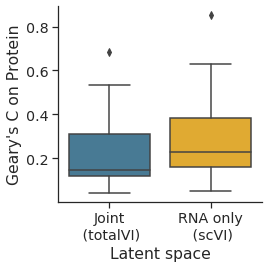

In [35]:
fig, ax = plt.subplots(figsize = (4, 4))

ax = sns.boxplot(data=geary)
ax.set(ylabel = "Geary's C on Protein")
ax.set(xlabel = "Latent space")

plt.tight_layout()
sns.despine()

#plt.savefig("figures/isoforms_gearyC.pdf", dpi=DPI, bbox_inches="tight")